신경망 학습의 순서를 확인해보자.
#### 전제 
신경망에는 적응 가능한 가중치와 편향이 있고, 이 가중치와 편향을 훈련 데이터에 적응하도록 조정하는 과정을 "학습"이라고 한다. 신경망 학습은 다음과 같이 4단계로 수행한다.
#### 1단계 - 미니배치
훈련 데이터 중 일부를 무작위로 가져온다. 이렇게 선별한 데이터를 미니배치라 하며, 그 미니배치의 손실 함수 값을 줄이는 것을 목표로 한다.
#### 2단계 - 기울기 산출
미니배치의 손실 함수 값을 줄이기 위해  각 가중치 매개변수의 기울기 값을 계산한다. 기울기는 손실 함수의 값을 가장 작게하는 방향을 제시한다.
#### 3단계 - 매개변수 갱신
가중치 매개변수를 기울기 방향으로 아주 조금 갱신한다.
#### 4단계 - 반복
1~3 단계를 반복한다.

이는 경사 하강법으로 매개변수를 갱신하는 방법이다. 이때 데이터를 미니배치로 무작위로 선정하기 때문에 "__확률적 경사 하강법(stochastic gradient descent)__"라고 부른다. 딥러닝 프레임워크는 이를 "__SGD__"라는 함수로 이 기능을 구현하고 있다.<br>
이제부터 MNIST 데이터셋을 사용하여 학습을 수행하자.

# 4.5.1 2층 신경망 클래스 구현하기

In [1]:
import numpy as np
import sys, os
sys.path.append(os.pardir)
from functions import Function

F = Function()

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        
        # 가중치 초기화
        self.params = {}
        self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params["b1"] = np.zeros(hidden_size)
        self.params["b2"] = np.zeros(output_size)
        
    def predict(self, x):
        
        W1, W2 = self.params["W1"], self.params["W2"]
        b1, b2 = self.params["b1"], self.params["b2"]
        
        a1 = x@W1 + b1
        z1 = F.sigmoid(a1)
        a2 = z1@W2 + b2
        y = F.softmax(a2)
        
        return y
    
    # x: 입력 데이터, t: 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        loss = F.cross_entropy_error(y, t)
        
        return loss
    
    def accuracy(y, t):
        y = self.predict(x)
        
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grd = {}
        grd["W1"] = F.numerical_gradient(loss_W, self.params["W1"])
        grd["W2"] = F.numerical_gradient(loss_W, self.params["W2"])
        grd["b1"] = F.numerical_gradient(loss_W, self.params["b1"])
        grd["b2"] = F.numerical_gradient(loss_W, self.params["b2"])
        
        return grd

In [2]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params["W1"].shape)
print(net.params["W2"].shape)
print(net.params["b1"].shape)
print(net.params["b2"].shape)

(784, 100)
(100, 10)
(100,)
(10,)


In [3]:
x = np.random.rand(100, 784)
y = net.predict(x)
print(y.ndim)

2


In [4]:
t = np.random.randn(100, 10)

grd = net.numerical_gradient(x, t)

print(grd["W1"].shape)
print(grd["W2"].shape)
print(grd["b1"].shape)
print(grd["b2"].shape)

(784, 100)
(100, 10)
(100,)
(10,)


우선 init 메소드는 클래스를 초기화 해준다. 받아들이는 인수는 순서대로 
1. input_size: 입력층 뉴런 수 
2. hidden_size: 은닉층 뉴런 수 
3. output_size: 출력층 뉴런 수 

이다.
예를 들어, 손글씨 숫자 인식에서는 크기가 $28 \times 28$인 입력 이미지가 총 784개 이고, 출력은 10개가 된다. 따라서 input_size=784, output_size=10이 되고, hidden_size는 적절히 선택해 주면 된다.<br>
이 초기화 메소드에서는 가중치 매개변수도 초기화한다. 가중치 매개변수의 초깃값을 무엇으로 설정하냐가 신경망 학습의 성공을 좌우하기도 한다. 지금은 매개변수는 정규분포를 따르는 난수로 정의하고, 편향은 0으로 하였다. predict(self, x)와 accuracy(self, x, t) 메소드는 앞에서 다룬 간단한 함수이다. loss(self, x, t) 메소드는 손실 함수의 값을 계산하도록 하는 메소드이다. 손실 함수는 cross_entropy_error 함수를 이용해 계산한다. 마지막 numerical_gradient(self, x, t) 메소드는 각 매개변수의 기울기를 계산한다. 수치미분 방식으로 각 매개변수의 손실 함수에 대한 기울기를 계산한다. 마지막 gradient(self, x, t)는 다음 장에서 구현할 메소드이다. 이 메소드는 오차역전파법을 사용하여 기울기를 효율적이고 빠르게 계산한다.

# 4.5.2 미니배치 학습 구현하기

In [ ]:
import numpy as np
from source.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# hyper parameter
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    
    # 기울기 계산
    grd = network.numerical_gradient(x_batch, t_batch)
    # grd = network.gradient(x_batch, t_batch) => 성능 개선판
    
    # 매개변수 갱신
    for key in ["W1", "W2", "b1", "b2"]:
        network.params[key] -= learning_rate * grd[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

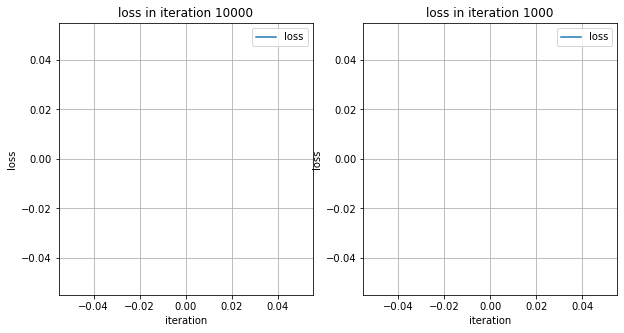

In [10]:
import matplotlib.pyplot as plt

l = np.arange(len(train_loss_list))

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(l, train_loss_list, label="loss")
plt.title("loss in iteration 10000")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(l[:1000], train_loss_list, label="loss")
plt.title("loss in iteration 1000")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.legend()
plt.grid()

plt.show()

<img src=images/4_11.png height=700px width=700px>
10000번으 실행한 결과와 1000번 실행된 결과를 확대한 이미지이다.

위의 이미지를 보면 학습 횟수가 늘어나면서 손실 함수의 값이 줄어든다. 이는 학습이 잘 되고 있다는 뜻으로, 신경망의 가중치 매개변수가 서서히 데이터에 적응하고 있음을 의미한다.

# 4.5.3 시험 데이터로 평가하기

위의 손실 함수의 값이란, 정확히는 "훈련 데이터의 미니배치의 대한 손실 함수"의 값이다. 훈련 데이터의 손실 함수 값이 작아지는 것은 신경망이 잘 학습하고 있다는 방증이지만, 이 결과만으로는 다른 데이터셋에도 비슷한 실력을 발휘할지는 확실하지 않다.<br>
신경망 학습에서는 "__오버피팅__"을 일으키지 않는지 확인해야 한다. 오버피팅 되었다는 것은 훈련 데이터에 포함된 이미지만 제대로 구분하고, 그렇지 않은 이미지는 식별할 수 없다는 뜻이다.<br>
신경망 학습의 원래 목표는 범용적인 능력을 익히는 것이다. 범용 능력을 평가하려면 훈련 데이터에 포함되지 않은 데이터를 사용해 평가해 봐야한다. 이를 위해 다음 구현에서는 학습 도중 정기적으로 훈련 데이터와 시험 데이터를 대상으로 정확도를 기록한다. 여기에서는 1에폭(epoch)별로 훈련 데이터와 시험 데이터에 대한 정확도를 기록한다.

In [ ]:
import numpy as np
from source.dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

# iteration number per 1 epoch
iter_per_epoch = max(train_size / batch_size, 1)

# hyper parameter
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    
    # 기울기 계산
    grd = network.numerical_gradient(x_batch, t_batch)
    # grd = network.gradient(x_batch, t_batch) => 성능 개선판
    
    # 매개변수 갱신
    for key in ["W1", "W2", "b1", "b2"]:
        network.params[key] -= learning_rate * grd[key]
        
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1epoch당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f"train acc, test acc | {train_acc}, {test acc}")

앞선 코드로 얻은 결과를 그래프로 그려보면 다음과 같다.
<img src=images/4_12.png height=700px, width=700px>

이 두 그래프가 거의 겹쳐져 있다는 뜻은, 오버피팅 없이 범용적인 가중치와 편향을 찾아내었다는 사실을 알려준다.